In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from  svhn import SVHNDataset
from datasets_utils import *
from mnist import MNISTDataset
from GTSRB_8 import GTSRB8_Dataset
from GTSRB_Util_split_MedFilt_Clahe import medfiltering as medfilter
from imagenet import ImageNetDataset
import itertools
from datasets_utils import get_correct_prediction_idx, evaluate_adversarial_examples, calculate_mean_confidence, calculate_accuracy

import os
import pdb
import pickle
import time
import random
from skimage import img_as_ubyte
import keras
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.platform import app
from tensorflow.python.platform import flags

FLAGS = flags.FLAGS

# flags.DEFINE_string('dataset_name', 'GTSRB-8', 'Supported: MNIST, CIFAR-10, ImageNet,GTSRB-8, SVHN.')
flags.DEFINE_string('dataset_name', 'GTSRB-8', 'Supported: MNIST, CIFAR-10, ImageNet,GTSRB-8, SVHN.')
flags.DEFINE_string('model_name', 'cleverhans', 'Supported: cleverhans, cleverhans_adv_trained and carlini for MNIST; carlini and DenseNet for CIFAR-10;  ResNet50, VGG19, Inceptionv3 and MobileNet for ImageNet; tohinz for SVHN.')
flags.DEFINE_boolean('select', True, 'Select correctly classified examples for the experiement.')
flags.DEFINE_boolean('balance_sampling', False, 'Select the same number of examples for each class.')
flags.DEFINE_boolean('test_mode', False, 'Only select one sample for each class.')
flags.DEFINE_integer('nb_examples', 100, 'The number of examples selected for attacks.')
flags.DEFINE_string('result_folder', "results", 'The output folder for results.')
flags.DEFINE_string('attacks',"FGSM?eps=0.1;BIM?eps=0.1andeps_iter=0.02;JSMA?targeted=next;CarliniL2?targeted=nextandbatch_size=100andmax_iterations=1000;CarliniL2?targeted=nextandbatch_size=100andmax_iterations=1000andconfidence=2", 'Attack name and parameters in URL style, separated by semicolon.')
flags.DEFINE_float('clip', -1, 'L-infinity clip on the adversarial perturbations.')
flags.DEFINE_boolean('visualize', True, 'Output the image examples for each attack, enabled by default.')
flags.DEFINE_boolean('verbose', False, 'Stdout level. The hidden content will be saved to log files anyway.')
# flags.DEFINE_string('detection', '', 'Supported: feature_squeezing.')
flags.DEFINE_string('detection', "FeatureSqueezing?squeezers=bit_depth_1&distance_measure=l1&fpr=0.05;FeatureSqueezing?squeezers=bit_depth_2&distance_measure=l1&fpr=0.05;FeatureSqueezing?squeezers=bit_depth_1,median_filter_2_2&distance_measure=l1&fpr=0.05;", 'Supported: feature_squeezing.')
flags.DEFINE_boolean('detection_train_test_mode', False, 'Split into train/test datasets.')

Using TensorFlow backend.
c:\ProgramData\anaconda3\envs\spd\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\ProgramData\anaconda3\envs\spd\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\ProgramData\anaconda3\envs\spd\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\ProgramData\anaconda3\envs\spd\lib\site-packages\t

Located Cleverhans
Located Carlini_nn_robust_attacks
Located Keras-deep-learning-models
Located MobileNets
Located Deepfool/Universal
Located DenseNet
Located MagNet


In [2]:
# FLAGS.model_name     = 'cleverhans'
FLAGS.dataset_name     = 'GTSRB-8'
# FLAGS.model_name       = 'carlini'
FLAGS.model_name       = 'densenet'
FLAGS.select           = True
FLAGS.balance_sampling = True
FLAGS.test_mode        = False
FLAGS.nb_examples      = 100
FLAGS.result_folder    = "results"
# FLAGS.attacks          ="carlinili?targeted=next&batch_size=100&max_iterations=1000andconfidence=10;"
# FLAGS.detection        ="FeatureSqueezing?squeezers=bit_depth_1anddistance_measure=l1andfpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_2anddistance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_1,median_filter_2_2&distance_measure=l1&fpr=0.05;"
FLAGS.attacks          ="fgsm?eps=0.0156;bim?eps=0.008&eps_iter=0.0012;\
carlinili?targeted=next&batch_size=16&confidence=5;carlinili?targeted=ll&batch_size=16&confidence=5;\
deepfool?overshoot=10;\
carlinil2?targeted=next&batch_size=16&max_iterations=1000&confidence=5;\
carlinil2?targeted=ll&batch_size=16&max_iterations=1000&confidence=5;\
carlinil0?targeted=next&batch_size=16&confidence=5;\
carlinil0?targeted=ll&batch_size=16&confidence=5;\
jsma?targeted=next;\
jsma?targeted=ll"
# FLAGS.attacks         = "FGSM?eps=0.0156"
# FLAGS.attacks         = "FGSM?eps=0.1;BIM?eps=0.1&eps_iter=0.02;JSMA?targeted=next;CarliniL2?targeted=next&batch_size=100&max_iterations=1000;"
# FLAGS.attacks         = "fgsm?eps=0.0156;bim?eps=0.008&eps_iter=0.0012;carlinili?targeted=next&confidence=5;carlinili?targeted=ll&confidence=5;deepfool?overshoot=10;carlinil2?targeted=next&batch_size=100&max_iterations=1000&confidence=5;carlinil2?targeted=ll&batch_size=100&max_iterations=1000&confidence=5;carlinil0?targeted=next&confidence=5;carlinil0?targeted=ll&confidence=5;jsma?targeted=next;jsma?targeted=ll;"
# FLAGS.attacks         = "fgsm?eps=0.0156;bim?eps=0.008&eps_iter=0.0012"

# FLAGS.detection = \
# "FeatureSqueezing?squeezers=bit_depth_1&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_2&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_3&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_4&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_5&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=median_filter_2_2&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=median_filter_3_3&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=non_local_means_color_11_3_2&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=non_local_means_color_11_3_4&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=non_local_means_color_13_3_2&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=non_local_means_color_13_3_4&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_5,median_filter_2_2,non_local_means_color_13_3_2&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_5,median_filter_2_2,non_local_means_color_13_3_4&distance_measure=l1&fpr=0.05;\
# FeatureSqueezing?squeezers=bit_depth_5,median_filter_2_2,non_local_means_color_11_3_4&distance_measure=l1&fpr=0.05;"
# FLAGS.detection = "FeatureSqueezing?squeezers=bit_depth_1&distance_measure=l1&fpr=0.05;"

FLAGS.detection = \
"FeatureSqueezing?squeezers=bit_depth_5,median_filter_3_3,non_local_means_color_13_3_2&distance_measure=l1&fpr=0.05;\
FeatureSqueezing?squeezers=bit_depth_5,median_filter_3_3,non_local_means_color_13_3_4&distance_measure=l1&fpr=0.05;\
FeatureSqueezing?squeezers=bit_depth_5,median_filter_3_3,non_local_means_color_11_3_4&distance_measure=l1&fpr=0.05;"
# FLAGS.clip             = -1
FLAGS.visualize        = True
FLAGS.verbose          = False

def load_tf_session():
    # Set TF random seed to improve reproducibility
    tf.set_random_seed(1234)

    # Create TF session and set as Keras backend session
    sess = tf.Session()
    keras.backend.set_session(sess)
    print("Created TensorFlow session and set Keras backend.")
    return sess

In [3]:
#Defining the dataset
if FLAGS.dataset_name == "GTSRB-8":
    dataset = GTSRB8_Dataset()


# 1. Load a dataset.
print("\n===Loading %s data..." % FLAGS.dataset_name)

if FLAGS.dataset_name == 'ImageNet':
    if FLAGS.model_name == 'inceptionv3':
        img_size = 299
    else:
        img_size = 224
    X_test_all, Y_test_all = dataset.get_test_data(img_size, 0, 200)
else:
    X_test_all, Y_test_all = dataset.get_test_dataset()

# 2. Load a trained model.

sess1 = load_tf_session()
keras.backend.set_learning_phase(0)
# Define input TF placeholder
x = tf.placeholder(tf.float32, shape=(None, dataset.image_size, dataset.image_size, dataset.num_channels))
y = tf.placeholder(tf.float32, shape=(None, dataset.num_classes))

with tf.variable_scope(FLAGS.model_name):
    """
    Create a model instance for prediction.
    The scaling argument, 'input_range_type': {1: [0,1], 2:[-0.5, 0.5], 3:[-1, 1]...}
    """
    model = dataset.load_model_by_name(FLAGS.model_name, logits=False, input_range_type=1)
    model.compile(loss='categorical_crossentropy',optimizer='sgd', metrics=['acc'])
model.summary()  


===Loading GTSRB-8 data...
Created TensorFlow session and set Keras backend.
Model created

===Defined TensorFlow model graph.
---Loaded GTSRB_8-densenet model.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
initial_conv2D (Conv2D)          (None, 64, 64, 16)    432         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 64, 64, 16)    64          initial_conv2D[0][0]             
____________________________________________________________________________________________________
activation_1 (Activation)    

In [4]:
# 3. Evaluate the trained model.
print ("Evaluating the pre-trained model...")
Y_pred_all    = model.predict(X_test_all)
mean_conf_all = calculate_mean_confidence(Y_pred_all, Y_test_all)
accuracy_all  = calculate_accuracy(Y_pred_all, Y_test_all)
print('Test accuracy on raw legitimate examples %.4f' % (accuracy_all))
print('Mean confidence on ground truth classes %.4f' % (mean_conf_all))

Evaluating the pre-trained model...
Test accuracy on raw legitimate examples 0.9682
Mean confidence on ground truth classes 0.9186


<function matplotlib.pyplot.show(close=None, block=None)>

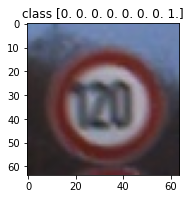

In [5]:
ind = 3
plt.subplot(121)
plt.title("class {}".format(Y_test_all[ind]))
plt.imshow(X_test_all[ind] )
plt.show

In [5]:
# 4. Select some examples to attack.
import hashlib
from datasets_utils import get_first_n_examples_id_each_class

if FLAGS.select:
    # Filter out the misclassified examples.
    correct_idx = get_correct_prediction_idx(Y_pred_all, Y_test_all)
    if FLAGS.test_mode:
        # Only select the first example of each class.
        correct_and_selected_idx = get_first_n_examples_id_each_class(Y_test_all[correct_idx])
        selected_idx = [ correct_idx[i] for i in correct_and_selected_idx ]
    else:
        if not FLAGS.balance_sampling:
            selected_idx = correct_idx[:FLAGS.nb_examples]
        else:
            # select the same number of examples for each class label.
            nb_examples_per_class = int(FLAGS.nb_examples / Y_test_all.shape[1])
            correct_and_selected_idx = get_first_n_examples_id_each_class(Y_test_all[correct_idx], n=nb_examples_per_class)
            selected_idx = [ correct_idx[i] for i in correct_and_selected_idx ]
else:
    selected_idx = np.array(range(FLAGS.nb_examples))

from utils.output import format_number_range
selected_example_idx_ranges = format_number_range(sorted(selected_idx))
print ( "Selected %d examples." % len(selected_idx))
print ( "Selected index in test set (sorted): %s" % selected_example_idx_ranges )
X_test, Y_test, Y_pred = X_test_all[selected_idx], Y_test_all[selected_idx], Y_pred_all[selected_idx]

# The accuracy should be 100%.
accuracy_selected = calculate_accuracy(Y_pred, Y_test)
mean_conf_selected = calculate_mean_confidence(Y_pred, Y_test)
print('Test accuracy on selected legitimate examples %.4f' % (accuracy_selected))
print('Mean confidence on ground truth classes, selected %.4f\n' % (mean_conf_selected))

task = {}
task['dataset_name'] = FLAGS.dataset_name
task['model_name'] = FLAGS.model_name
task['accuracy_test'] = accuracy_all
task['mean_confidence_test'] = mean_conf_all

task['test_set_selected_length'] = len(selected_idx)
task['test_set_selected_idx_ranges'] = selected_example_idx_ranges
task['test_set_selected_idx_hash'] = hashlib.sha1(str(selected_idx).encode('utf-8')).hexdigest()
task['accuracy_test_selected'] = accuracy_selected
task['mean_confidence_test_selected'] = mean_conf_selected

task_id = "%s_%d_%s_%s" % \
        (task['dataset_name'], task['test_set_selected_length'], task['test_set_selected_idx_hash'][:5], task['model_name'])

FLAGS.result_folder = os.path.join(FLAGS.result_folder, task_id)
if not os.path.isdir(FLAGS.result_folder):
    print("Making the Folder %s" % FLAGS.result_folder)
    os.makedirs(FLAGS.result_folder)

Selected 96 examples.
Selected index in test set (sorted): 0-29:1,31-54:1,56-59:1,61,65,66,68-71:1,73,75,76,78,81,83,86,90-92:1,95,105,107,115,127,132,138,156,170,177,192,542,1317,1377,1634,1726,1764,1957,1971,2068,2152
Test accuracy on selected legitimate examples 1.0000
Mean confidence on ground truth classes, selected 0.9133



In [6]:
# 5. Generate adversarial examples.
from attacks import maybe_generate_adv_examples
from utils.squeeze import reduce_precision_py
from utils.parameter_parser import parse_params
attack_string_hash = hashlib.sha1(FLAGS.attacks.encode('utf-8')).hexdigest()[:5]
sample_string_hash = task['test_set_selected_idx_hash'][:5]

from datasets_utils import get_next_class, get_least_likely_class
Y_test_target_next = get_next_class(Y_test)
Y_test_target_ll = get_least_likely_class(Y_pred)

X_test_adv_list = []
X_test_adv_discretized_list = []
Y_test_adv_discretized_pred_list = []

attack_string_list = filter(lambda x:len(x)>0, FLAGS.attacks.lower().split(';'))
to_csv = []

X_adv_cache_folder = os.path.join(FLAGS.result_folder, 'adv_examples')
adv_log_folder = os.path.join(FLAGS.result_folder, 'adv_logs')
predictions_folder = os.path.join(FLAGS.result_folder, 'predictions')
for folder in [X_adv_cache_folder, adv_log_folder, predictions_folder]:
    if not os.path.isdir(folder):
        os.makedirs(folder)

predictions_fpath = os.path.join(predictions_folder, "legitimate.npy")
np.save(predictions_fpath, Y_pred, allow_pickle=False)

In [7]:
# attack_names_extracted = []
# attack_string_list  = filter(lambda x:len(x)>0, FLAGS.attacks.lower().split(';'))
# for attack_string in attack_string_list:
#     attack_name, attack_params = parse_params(attack_string)
#     print ( "\nRunning attack: %s %s" % (attack_name, attack_params))
#     attack_names_extracted.append(attack_name)

In [7]:
if FLAGS.clip >= 0:
    epsilon = FLAGS.clip
    print ("Clip the adversarial perturbations by +-%f" % epsilon)
    max_clip = np.clip(X_test + epsilon, 0, 1)
    min_clip = np.clip(X_test - epsilon, 0, 1)
attack_string_list = filter(lambda x:len(x)>0, FLAGS.attacks.lower().split(';'))
for attack_string in attack_string_list:
    attack_log_fpath = os.path.join(adv_log_folder, "%s_%s.log" % (task_id, attack_string.replace("?","_")))
    attack_name, attack_params = parse_params(attack_string)
    print ( "\nRunning attack: %s %s" % (attack_name, attack_params))

    if 'targeted' in attack_params:
        targeted = attack_params['targeted']
        print ("targeted value: %s" % targeted)
        if targeted == 'next':
            Y_test_target = Y_test_target_next
        elif targeted == 'll':
            Y_test_target = Y_test_target_ll
        elif targeted == False:
            attack_params['targeted'] = False
            Y_test_target = Y_test.copy()
    else:
        targeted = False
        attack_params['targeted'] = False
        Y_test_target = Y_test.copy()

    x_adv_fname = "%s_%s.pickle" % (task_id, attack_string.replace("?","_"))
    x_adv_fpath = os.path.join(X_adv_cache_folder, x_adv_fname)

    X_test_adv, aux_info = maybe_generate_adv_examples(sess1, model, x, y, X_test, Y_test_target, attack_name, attack_params,
                                                        use_cache = x_adv_fpath, verbose=FLAGS.verbose, attack_log_fpath=attack_log_fpath)

    if FLAGS.clip > 0:
        # This is L-inf clipping.
        X_test_adv = np.clip(X_test_adv, min_clip, max_clip)

    X_test_adv_list.append(X_test_adv)

    if isinstance(aux_info, float):
        duration = aux_info
    else:
        duration = aux_info['duration']

    dur_per_sample = duration / len(X_test_adv)

    # 5.0 Output predictions.
    Y_test_adv_pred = model.predict(X_test_adv)
    predictions_fpath = os.path.join(predictions_folder, "%s.npy"% attack_string.replace("?","_"))
    np.save(predictions_fpath, Y_test_adv_pred, allow_pickle=False)

    # 5.1 Evaluate the adversarial examples being discretized to uint8.
    print ("\n---Attack (uint8): %s" % attack_string)
    # All data should be discretized to uint8.
    X_test_adv_discret = reduce_precision_py(X_test_adv, 256)
    X_test_adv_discretized_list.append(X_test_adv_discret)
    Y_test_adv_discret_pred = model.predict(X_test_adv_discret)
    Y_test_adv_discretized_pred_list.append(Y_test_adv_discret_pred)

    rec = evaluate_adversarial_examples(X_test, Y_test, X_test_adv_discret, Y_test_target.copy(), targeted, Y_test_adv_discret_pred)
    rec['dataset_name'] = FLAGS.dataset_name
    rec['model_name'] = FLAGS.model_name
    rec['attack_string'] = attack_string.replace("?","_")
    rec['duration_per_sample'] = dur_per_sample
    rec['discretization'] = True
    to_csv.append(rec)


Running attack: fgsm {'eps': 0.0156}
Loading adversarial examples from [GTSRB-8_96_8dfa8_densenet_fgsm_eps=0.0156.pickle].

---Attack (uint8): fgsm?eps=0.0156
Success rate: 77.08%, Mean confidence of SAEs: 95.60%
### Statistics of the SAEs:
L2 dist: 1.7321, Li dist: 0.0157, L0 dist_value: 99.5%, L0 dist_pixel: 100.0%

Running attack: bim {'eps': 0.008, 'eps_iter': 0.0012}
Loading adversarial examples from [GTSRB-8_96_8dfa8_densenet_bim_eps=0.008&eps_iter=0.0012.pickle].

---Attack (uint8): bim?eps=0.008&eps_iter=0.0012
Success rate: 86.46%, Mean confidence of SAEs: 97.73%
### Statistics of the SAEs:
L2 dist: 0.7518, Li dist: 0.0078, L0 dist_value: 93.5%, L0 dist_pixel: 99.9%

Running attack: carlinili {'targeted': 'next', 'batch_size': 16, 'confidence': 5.0}
targeted value: next
Loading adversarial examples from [GTSRB-8_96_8dfa8_densenet_carlinili_targeted=next&batch_size=16&confidence=5.pickle].

---Attack (uint8): carlinili?targeted=next&batch_size=16&confidence=5
Success rate: 100

In [9]:
# from utils.output import write_to_csv
# attacks_evaluation_csv_fpath = os.path.join(FLAGS.result_folder, 
#         "%s_attacks_%s_evaluation.csv" % \
#         (task_id, attack_string_hash))
# fieldnames = ['dataset_name', 'model_name', 'attack_string', 'duration_per_sample', 'discretization', 'success_rate', 'mean_confidence', 'mean_l2_dist', 'mean_li_dist', 'mean_l0_dist_value', 'mean_l0_dist_pixel']
# write_to_csv(to_csv, attacks_evaluation_csv_fpath, fieldnames)

In [8]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np
import random
import pdb
import sklearn
import os

from sklearn.metrics import roc_curve, auc
from feature_squeezing import FeatureSqueezingDetector
from magnet_mnist import MagNetDetector as MagNetDetectorMNIST
from magnet_cifar import MagNetDetector as MagNetDetectorCIFAR

from tensorflow.python.platform import flags
FLAGS = flags.FLAGS
from utils.output import write_to_csv
from Segmentation_detector import SegmentationDetector 

def get_tpr_fpr(true_labels, pred_labels):
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

    AP = np.sum(true_labels)
    AN = np.sum(1-true_labels)

    tpr = TP/AP if AP>0 else np.nan
    fpr = FP/AN if AN>0 else np.nan

    return tpr, fpr, TP, AP


def evalulate_detection_test(Y_detect_test, Y_detect_pred):
    accuracy = sklearn.metrics.accuracy_score(Y_detect_test, Y_detect_pred, normalize=True, sample_weight=None)
    tpr, fpr, tp, ap = get_tpr_fpr(Y_detect_test, Y_detect_pred)
    return accuracy, tpr, fpr, tp, ap


from tinydb import TinyDB, Query

class DetectionEvaluator:
    """
    Get a dataset;
        Failed adv as benign / Failed adv as adversarial.
    For each detector:
        Train
        Test
        Report performance
            Detection rate on each attack.
            Detection on SAEs / FAEs.
            ROC-AUC.

    A detector should have this simplified interface:
        Y_pred = detector(X)
    """
    def __init__(self, model, result_folder, csv_fname, dataset_name):
        pass
        # set_base_model()
        self.model = model
        self.task_dir = result_folder
        self.csv_fpath = os.path.join(result_folder, csv_fname)
        print(self.csv_fpath)
        self.dataset_name = dataset_name

        if not os.path.isdir(self.task_dir):
            os.makedirs(self.task_dir)

    def get_attack_id(self, attack_name):
        return self.attack_name_id[attack_name]

    def build_detection_dataset(self, X, Y_label, Y_pred, selected_idx, X_adv_list, Y_adv_pred_list,
                                 attack_names, attack_string_hash, clip, Y_test_target_next, Y_test_target_ll):
        # X_train, Y_train, X_test, Y_test, test_idx, failed_adv_idx = \
        #     get_detection_train_test_set(X, Y_label, X_adv_list, Y_adv_pred_list, attack_names)

        """
        Data Model:
            index, attack_id, misclassified, train
            14,     0,           0,             1
        """

        self.attack_names = attack_names.lower().split(';')
        self.attack_name_id = {}
        self.attack_name_id['legitimate'] = 0
        # attack_names = filter(lambda x:len(x)>0, attack_names.lower().split(';'))
        attack_names = attack_names.lower().split(';')
        for i,attack_name in enumerate(attack_names):
            # print("AttackNames",i,attack_name)
            self.attack_name_id[attack_name] = i+1
            # print(self.attack_name_id[attack_name])

        X_adv_all = np.concatenate(X_adv_list)
        X_leg_all = X[:len(X_adv_all)]
        # print(len(X_leg_all),"kkkkkkk")
        self.X_detect = X_detect = np.concatenate([X_leg_all, X_adv_all])
        # TODO: this could be wrong in non-default data selection mode.
        Y_label_adv = Y_label[selected_idx]

        detection_db_path = os.path.join(self.task_dir, "detection_db_%s_clip_%s.json" % (attack_string_hash, clip))

        if os.path.isfile(detection_db_path):
            self.db = TinyDB(detection_db_path)
            self.query = Query()
            print ("Loaded an existing detection dataset.")
            return
        else:
            print ("Preparing the detection dataset...")

        # 1. Split Train and Test 
        random.seed(1234)
        length = len(X_detect)
        train_ratio = 0.5
        train_idx = random.sample(range(length), int(train_ratio*length))
        train_test_seq = [1 if idx in train_idx else 0 for idx in range(length) ]

        # 2. Tag the misclassified examples, both legitimate and adversarial.
        # TODO: Differentiate the successful examples between targeted and non-targeted.
        misclassified_seq = list(np.argmax(Y_label[:len(X_leg_all)], axis=1) != np.argmax(Y_pred[:len(X_leg_all)], axis=1))
        for Y_adv_pred in Y_adv_pred_list:
            misclassified_seq_adv = list(np.argmax(Y_adv_pred, axis=1) != np.argmax(Y_label_adv, axis=1))
            misclassified_seq += misclassified_seq_adv

        success_adv_seq = [False] * len(X_leg_all)
        for ( Y_adv_pred),(attack_name_i) in zip(Y_adv_pred_list,attack_names):
            attack_name = attack_name_i
            if 'targeted=ll' in attack_name:
                # print("Yes LL")
                success_adv_seq_attack = list(np.argmax(Y_adv_pred, axis=1) == np.argmax(Y_test_target_ll, axis=1))
            elif 'targeted=next' in attack_name:
                # print("Yes Next")
                success_adv_seq_attack = list(np.argmax(Y_adv_pred, axis=1) == np.argmax(Y_test_target_next, axis=1))
            else:
                # The same as misclassified.
                success_adv_seq_attack = list(np.argmax(Y_adv_pred, axis=1) != np.argmax(Y_label_adv, axis=1))
            success_adv_seq += success_adv_seq_attack



        # 3. Tag the attack ID, 0 as legitimate.
        attack_id_seq = [0]*len(X_leg_all)
        # attack_id_seq = [0]*len(X_detect)
        # print("Hello_Hi")
        # print(len(attack_names),len(attack_id_seq))
        for i,attack_name in enumerate(attack_names):
            attack_id_seq += [i+1]*len(X_adv_list[0])
            # print("Hello_friend")
        # print(len(X_detect) , len(train_test_seq) , len(misclassified_seq) , len(attack_id_seq))
        assert len(X_detect) == len(train_test_seq) == len(misclassified_seq) == len(attack_id_seq)
        # assert len(X_detect) == len(train_test_seq) == len(misclassified_seq)

        self.db = TinyDB(detection_db_path)
        self.query = Query()
        # print(len(attack_id_seq),len(X_detect))
        for i in range(len(X_detect)):
            attack_id = attack_id_seq[i]
            misclassified = 1 if misclassified_seq[i] == True else 0
            success = 1 if success_adv_seq[i] == True else 0
            train = train_test_seq[i]
            rec = {'index': i, 'attack_id': attack_id, 'misclassified': misclassified, 'success': success, 'train': train}
            self.db.insert(rec)

    def get_data_from_db_records(self, recs):
        if len(recs) == 0:
            return None, None
        X_idx = [rec['index'] for rec in recs]
        X = self.X_detect[np.array(X_idx)]
        Y = np.array([1 if rec['attack_id']>0 else 0 for rec in recs])
        return X, Y

    def get_training_testing_data(self, train = True):
        db = self.db
        query = self.query

        recs = db.search(query.train == 1)
        X_train, Y_train = self.get_data_from_db_records(recs)

        recs = db.search(query.train == 0)
        X_test, Y_test = self.get_data_from_db_records(recs)

        return X_train, Y_train, X_test, Y_test

    def get_adversarial_data(self, only_testing, success, attack_name=None, include_legitimate=False):
        db = self.db
        query = self.query

        conditions_and = []
        if only_testing:
            conditions_and.append(query.train == 0)

        if attack_name is None:
            conditions_and.append(query.attack_id > 0)
            # print(query.attack_id,"1")
        else:
            # print(attack_name,"2")
            attack_id = self.get_attack_id(attack_name)
            conditions_and.append(query.attack_id == attack_id)

        if success:
            conditions_and.append(query.success == 1)
        else:
            conditions_and.append(query.success == 0)

        conditions = reduce(lambda a,b:a&b, conditions_and)
        print ("conditions: %s " % conditions)

        recs = db.search(conditions)

        if include_legitimate:
            if only_testing:
                conditions = (query.attack_id == 0) & (query.train == 0)
            else:
                conditions = query.attack_id == 0
            # print ("additional conditions: %s " % conditions)
            recs += db.search(conditions)

        return self.get_data_from_db_records(recs)

    def get_sae_testing_data(self, attack_name=None):
        return self.get_adversarial_data(only_testing=True, success=True, attack_name=attack_name)

    def get_sae_data(self, attack_name=None):
        return self.get_adversarial_data(only_testing=False, success=True, attack_name=attack_name)

    def get_fae_testing_data(self, attack_name=None):
        return self.get_adversarial_data(only_testing=True, success=False, attack_name=attack_name)

    def get_fae_data(self, attack_name=None):
        return self.get_adversarial_data(only_testing=False, success=False, attack_name=attack_name)

    def get_all_non_fae_testing_data(self, attack_name=None):
        return self.get_adversarial_data(only_testing=True, success=True, attack_name=attack_name, include_legitimate=True)

    def get_all_non_fae_data(self, attack_name=None):
        return self.get_adversarial_data(only_testing=False, success=True, attack_name=attack_name, include_legitimate=True)

    def get_detector_by_name(self, detector_name):
        model = self.model
        detector = None

        if detector_name.startswith('FeatureSqueezing'):
            detector = FeatureSqueezingDetector(model, detector_name)
        elif detector_name.startswith('Segmentation'):
            detector = SegmentationDetector()
        elif detector_name.startswith('MagNet'):
            if self.dataset_name == 'MNIST':
                detector = MagNetDetectorMNIST(model, detector_name)
            elif self.dataset_name == "CIFAR-10":
                detector = MagNetDetectorCIFAR(model, detector_name)

        return detector

    def evaluate_detections(self, params_str,X_test_all,Y_test_all):
        X_train, Y_train, X_test, Y_test = self.get_training_testing_data()
        # print(Y_test)
        # Example: --detection "FeatureSqueezing?distance_measure=l1&squeezers=median_smoothing_2,bit_depth_4;"
        detector_names = [ele.strip() for ele in params_str.split(';') if ele.strip()!= '']
        dataset_name = self.dataset_name
        csv_fpath = "./segmentation_detection_%s_saes.csv" % dataset_name 
        fieldnames = ['detector', 'threshold', 'fpr','fpr_all_test_clean','Accuracy_all_test_clean'] + list(self.attack_names) + ['overall']
        print(fieldnames)
        to_csv = []

        for detector_name in detector_names:
            detector = self.get_detector_by_name(detector_name)
            if detector is None:
                print ("Skipped an unknown detector [%s]" % detector_name.split('?')[0])
                continue
            detector.train(X_train, Y_train)
            Y_test_pred, Y_test_pred_score = detector.test(X_test)
            # print( "Hello Boy" )
            accuracy, tpr, fpr, tp, ap = evalulate_detection_test(Y_test, Y_test_pred)
            fprs, tprs, thresholds = roc_curve(Y_test, Y_test_pred_score)
            roc_auc = auc(fprs, tprs)
            print( "\n" )
            print ("Detector: %s" % detector_name)
            print( "\n" )
            print ("Accuracy: %f\tTPR: %f\tFPR: %f\tROC-AUC: %f" % (accuracy, tpr, fpr, roc_auc))

            Y_test_pred_t, Y_test_pred_score_t = detector.test(X_test_all)
            # print(Y_test_pred_t[0], "Hello Boy" )
            Y_test_thresh = np.zeros(np.array(np.argmax(Y_test_all,axis=1)).shape) 
            accuracy_all, tpr_all, fpr_all, tp_all, ap_all = evalulate_detection_test(Y_test_thresh, Y_test_pred_t)
            print("Accuracy_all_test:%.3f" % accuracy_all," FPR_all_test:%.3f" % fpr_all,"For all TestSet")
            
            rec = {}
            rec['detector'] = detector_name
            if hasattr(detector, 'threshold'):
                rec['threshold'] = detector.threshold
            else:
                rec['threshold'] = None
            rec['fpr'] = fpr
            rec['Accuracy_all_test_clean'] = accuracy_all
            rec['fpr_all_test_clean'] = fpr_all
            overall_detection_rate_saes = 0
            nb_saes = 0
            for attack_name in self.attack_names:
                print( "\n" )
                # No adversarial examples for training for the current detection methods.
                # X_sae, Y_sae = self.get_sae_testing_data(attack_name)
                if FLAGS.detection_train_test_mode:
                    print(attack_name)
                    X_sae, Y_sae = self.get_sae_testing_data(attack_name)
                else:
                    X_sae, Y_sae = self.get_sae_data(attack_name)
                Y_test_pred, Y_test_pred_score = detector.test(X_sae)
                # print(Y_sae,Y_test_pred,"Hala Madrid")
                _, tpr, _, tp, ap = evalulate_detection_test(Y_sae, Y_test_pred)
                print ("Detection rate on SAEs: %.4f \t %3d/%3d \t %s" % (tpr, tp, ap, attack_name))
                overall_detection_rate_saes += tpr * len(Y_sae)
                nb_saes += len(Y_sae)
                rec[attack_name] = tpr
                # print ("overall_detection_rate_saes/nb_saes: %d/%d" % (overall_detection_rate_saes, nb_saes))
            # print(len(nb_saes))
            print(nb_saes)
            print ("Overall detection rate on SAEs: %f (%d/%d)" % (overall_detection_rate_saes/nb_saes, overall_detection_rate_saes, nb_saes))
            rec['overall'] = float(overall_detection_rate_saes/nb_saes)
            to_csv.append(rec)

            # No adversarial examples for training for the current detection methods.
            # X_sae_all, Y_sae_all = self.get_sae_testing_data()
            print ("### Excluding FAEs:")
            if FLAGS.detection_train_test_mode:
                X_nfae_all, Y_nfae_all = self.get_all_non_fae_testing_data()
            else:
                X_nfae_all, Y_nfae_all = self.get_all_non_fae_data()
            Y_pred, Y_pred_score = detector.test(X_nfae_all)
            _, tpr, _, tp, ap = evalulate_detection_test(Y_nfae_all, Y_pred)
            fprs, tprs, thresholds = roc_curve(Y_nfae_all, Y_pred_score)

            # print ("threshold\tfpr\ttpr")
            # for i, threshold  in enumerate(thresholds):
            #     print ("%.4f\t%.4f\t%.4f" % (threshold, fprs[i], tprs[i]))

            roc_auc = auc(fprs, tprs)
            print ("Overall TPR: %f\tROC-AUC: %f" % (tpr, roc_auc))

            # FAEs
            if FLAGS.detection_train_test_mode:
                X_fae, Y_fae = self.get_fae_testing_data()
            else:
                X_fae, Y_fae = self.get_fae_data()
            Y_test_pred, Y_test_pred_score = detector.test(X_fae)
            _, tpr, _, tp, ap = evalulate_detection_test(Y_fae, Y_test_pred)
            print ("Overall detection rate on FAEs: %.4f \t %3d/%3d" % (tpr, tp, ap))
        # print(csv_fpath,fieldnames)
        write_to_csv(to_csv, csv_fpath, fieldnames)

In [ ]:
# if FLAGS.detection != '':
#     # from detections.base import DetectionEvaluator

#     result_folder_detection = os.path.join(FLAGS.result_folder, "detection")
#     csv_fname = "%s_attacks_%s_detection.csv" % (task_id, attack_string_hash)
#     de = DetectionEvaluator(model, result_folder_detection, csv_fname, FLAGS.dataset_name)
#     Y_test_all_pred = model.predict(X_test_all)
#     attack_string_list = filter(lambda x:len(x)>0, FLAGS.attacks.lower().split(';'))
#     # de.build_detection_dataset(X_test_all, Y_test_all, Y_test_all_pred, selected_idx, X_test_adv_discretized_list, Y_test_adv_discretized_pred_list, attack_string_list, attack_string_hash, FLAGS.clip, Y_test_target_next, Y_test_target_ll)
#     de.build_detection_dataset(X_test_all, Y_test_all, Y_test_all_pred, selected_idx, X_test_adv_discretized_list, Y_test_adv_discretized_pred_list,
#                                 FLAGS.attacks, attack_string_hash, FLAGS.clip, Y_test_target_next, Y_test_target_ll)
#     de.evaluate_detections(FLAGS.detection,X_test_all,Y_test_all)

In [20]:
from keras import layers
from keras import backend as K
GTSRB_8_Dense_model = keras.models.Model(inputs = model.input, outputs = model.layers[156].output)

def identity_loss(y_true, y_pred):
    return K.mean(y_pred)
def triplet_loss(x, alpha = 1):
# def triplet_loss(x, alpha = 10):
# def triplet_loss(x, alpha = 30):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

anchor_input   = layers.Input((64, 64, 3),name="anchor"  )
positive_input = layers.Input((64, 64, 3),name="positive")    
negative_input = layers.Input((64, 64, 3),name="negative") 
# embedding_network = CIFAR_10_Dense_model   

# tower_1 = embedding_network(anchor_input)
normal_layer_1 = keras.layers.BatchNormalization(name="bat_1")(GTSRB_8_Dense_model.output)
# normal_layer_1 = layers.Dense(512, activation="relu")(normal_layer_1)
# normal_layer_1 = keras.layers.BatchNormalization(name="bat_2")(normal_layer_1)
normal_layer_1 = layers.Dense(64, activation="relu")(normal_layer_1)

embedding = keras.models.Model(GTSRB_8_Dense_model.input, normal_layer_1, name="Embedding")

A = embedding(anchor_input  )
P = embedding(positive_input)
N = embedding(negative_input)

loss = layers.Lambda(triplet_loss)([A, P, N])

siamese_network = keras.models.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=loss )
# siamese_network.load_weights("Triplets/ep_alpha1_01_los1.056_GTSRB_Triplets_adv.h5")
siamese_network.load_weights("C:/Users/ahmad/Desktop/JupyterFilesAUB/GTSRB_dataset/Siamese_Triplets/ep_alpha1_01_los0.206_GTSRB_Triplets_adv.h5")
siamese_network.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
anchor (InputLayer)              (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
positive (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
negative (InputLayer)            (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
Embedding (Model)                (None, 64)            1063856     anchor[0][0]                     
                                                                   positive[0][0]          

In [10]:
X_train      = []
X_train_orig = []
Y_train      = []
classes_str  = ['00000','00001','00002','00003',
                '00004','00005','00007','00008']
dim = 64
cur_path = 'C:/Users/ahmad/Desktop/JupyterFilesAUB/GTSRB_dataset/Final_Training/Train_Images_Edit_Ver' 
q = -1
for i in classes_str: 
  q+=1
  path = os. path.join(cur_path, i) 
  images = os.listdir(path) 
  for a in images: 
    try: 
      # image1 = cv2.cvtColor(cv2.imread(path + '/'+ a), cv2.COLOR_BGR2GRAY)
      # image1 = cv2.resize(image1, (dim, dim))
      image = cv2.cvtColor(cv2.imread(path + '/'+ a), cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (dim, dim)) 
      X_train     .append(image) 
      # X_train_orig.append(image1)
      Y_train     .append(q) 
    except: 
      print("Error loading image"+path + '/'+ a) 
X_train = np.array(X_train)
Y_train = np.array(Y_train)
print(len(Y_train))

8140


In [11]:
train_images = medfilter(X_train)
train_images = train_images.astype(np.float32)/255
train_labels = Y_train

MedClahe_Filtering...


In [12]:
################################################################################################################################
# import json 
from keras.layers import BatchNormalization
from numpy.linalg import norm
IMG_CHANNELS = 1
dim          = 64
IMG_WIDTH    = dim
IMG_HEIGHT   = dim
#Build the model
inputs = keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
# s = keras.layers.Lambda(lambda x: x / 255)(inputs)

#Contraction path
c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
b1 = BatchNormalization()(c1)
c1 = keras.layers.Dropout(0.1)(b1)
c1 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
b1 = BatchNormalization()(c1)
p1 = keras.layers.MaxPooling2D((2, 2))(b1)

c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
b2 = BatchNormalization()(c2)
c2 = keras.layers.Dropout(0.1)(b2)
c2 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
b2 = BatchNormalization()(c2)
p2 = keras.layers.MaxPooling2D((2, 2))(b2)

c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
b3 = BatchNormalization()(c3)
c3 = keras.layers.Dropout(0.2)(b3)
c3 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
b3 = BatchNormalization()(c3)
p3 = keras.layers.MaxPooling2D((2, 2))(b3)

c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
b4 = BatchNormalization()(c4)
c4 = keras.layers.Dropout(0.2)(b4)
c4 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
b4 = BatchNormalization()(c4)
p4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(b4)

c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
b5 = BatchNormalization()(c5)
c5 = keras.layers.Dropout(0.3)(b5)
c5 = keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
b5 = BatchNormalization()(c5)

#Expansive path 
u6 = keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(b5)
u6 = keras.layers.concatenate([u6, c4])
c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
b6 = BatchNormalization()(c6)
c6 = keras.layers.Dropout(0.2)(b6)
c6 = keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
b6 = BatchNormalization()(c6)

u7 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(b6)
u7 = keras.layers.concatenate([u7, c3])
c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
b7 = BatchNormalization()(c7)
c7 = keras.layers.Dropout(0.2)(b7)
c7 = keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
b7 = BatchNormalization()(c7)

u8 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(b7)
u8 = keras.layers.concatenate([u8, c2])
c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
b8 = BatchNormalization()(c8)
c8 = keras.layers.Dropout(0.1)(b8)
c8 = keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
b8 = BatchNormalization()(c8)

u9 = keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(b8)
u9 = keras.layers.concatenate([u9, c1], axis=3)
c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
b9 = BatchNormalization()(c9)
c9 = keras.layers.Dropout(0.1)(b9)
c9 = keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
b9 = BatchNormalization()(c9)

outputs = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(b9)

graph_U_Net = tf.get_default_graph()
with graph_U_Net.as_default():
    session_U_Net = tf.Session()
    with session_U_Net.as_default():
        U_Net_Model = keras.models.Model(inputs=[inputs], outputs=[outputs])
    U_Net_Model.load_weights("C:/Users/ahmad/Desktop/JupyterFilesAUB/GTSRB_dataset/checkpointsUnet/allTset_ep_15_acc0.95195_GTSRB_UNet.h5")
    U_Net_Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
###############################################################################################

In [13]:
filename = 'C:/Users/ahmad/Desktop/JupyterFilesAUB/GTSRB_dataset/checkpointsSVM/one_svm_model_GTSRB.sav'
OC_SVM_model = pickle.load(open(filename, 'rb'))

c:\ProgramData\anaconda3\envs\spd\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator OneClassSVM from version 1.3.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [24]:
def test(X_test,Y_test,threshold, flag):
        adv_cls = 10
        x_adv_SVM = np.zeros(len(Y_test))
        X_test_ = []
        for img in X_test:
            # image = cv2.resize(img, (dim,dim)) #64*64*1 Images
            img_uint8 = np.clip(np.rint(img * 255), 0, 255).astype(np.uint8)
            image = cv2.cvtColor(img_uint8,cv2.COLOR_RGB2GRAY)
            image = np.expand_dims(image, axis=2)
            X_test_.append(image)
        X_test_ = np.array(X_test_)
        X_test_U = X_test_/255.
        X_test_mask           = U_Net_Model.predict(X_test_U,verbose=0)
        X_test_preds_mask_t   = (X_test_mask > 0.5).astype(np.uint8)
        X_test_masks          = np.array(X_test_preds_mask_t)
        adv_labels_SVM = x_adv_SVM
        X_adv_OCsvm = X_test_masks.reshape((len(X_test_masks), -1))
        result = OC_SVM_model.predict(X_adv_OCsvm )
        oc_indices = np.where(result==-1)[0]
        adv_labels_SVM[oc_indices] = adv_cls
#############################################################
        Y_test  = np.array(Y_test )
        X_test_orig       = []
        for img in X_test:
            img_uint8 = np.clip(np.rint(img * 255), 0, 255).astype(np.uint8)
            X_test_orig.append(img_uint8)
        X_test_orig = medfilter(X_test_orig)
        X_test_orig = np.array (X_test_orig)
        # X_test_orig = X_test_orig.reshape(X_test_orig.shape[0],X_test_orig.shape[1],X_test_orig.shape[2],1)
        # X_test_orig  = X_test_orig.astype(np.float32)/255
        # print(X_test_orig.shape)
        num_classes_clean   = max(train_labels) + 1
        digit_indices_clean = [np.where(np.array(train_labels) == i)[0] for i in range(int(num_classes_clean))]
        siamese_labels_1    = []
        for idx1 in range(len(X_test_orig)):
            # add a matching example
            x1     = X_test_orig [idx1]
            label1 = Y_test      [idx1]
            x1     = x1/255.
            idx2   = random.choice(digit_indices_clean[label1])
            x2     = train_images[idx2]
            idx3   = random.choice(digit_indices_clean[label1])
            x3     = train_images[idx3]#Two_Sample
            anchor   = embedding.predict(np.expand_dims(x1, axis=0),verbose = 0)
            positive = embedding.predict(np.expand_dims(x2, axis=0),verbose = 0)
            positive3 = embedding.predict(np.expand_dims(x3, axis=0),verbose = 0)#Two_Sample

            anchor   = np.reshape(anchor  ,64)
            positive = np.reshape(positive,64)
            positive3 = np.reshape(positive3,64)#Two_Sample
            pos_dist = np.dot(anchor,positive)/(norm(anchor)*norm(positive))
            pos_dist3 = np.dot(anchor,positive3)/(norm(anchor)*norm(positive3))#Two_Sample
            pos_dist_final = min(pos_dist,pos_dist3)#Two_Sample

            siamese_labels_1.append(pos_dist_final)#Two_Sample
            # siamese_labels_1.append(pos_dist)
            # print(pos_dist)

        print(len(siamese_labels_1))
        print(siamese_labels_1[0])
        if len(siamese_labels_1) !=0:
            x_ = np.zeros(len(siamese_labels_1))
            x_[np.where(np.array(siamese_labels_1)>threshold)[0]] = 1
            res = len(np.where(x_==0)[0])/len(siamese_labels_1)
            print("Siamese_Detection",res,"%")
            x_[oc_indices] = 0     #SVM Detection
            return x_== 0 # inverse logic

In [25]:
print("Hello Segmentation")
# detector_names = [ele.strip() for ele in params_str.split(';') if ele.strip()!= '']
attack_names = FLAGS.attacks.lower().split(';')
dataset_name = "GTSRB_8"
# detector_name = "Siamese_detector_Two_Sample_Med_Clahe_SVM"
# csv_fpath = "./Siamese_detection_Two_Sample_Med_Clahe_SVM_%s_saes_05_thresh.csv" % dataset_name 
detector_name = "Siamese_detector_Med_Clahe_SVM"
csv_fpath = "./Siamese_detection_Med_Clahe_SVM_%s_saes_05_thresh.csv" % dataset_name 
fieldnames = ['detector', 'threshold', 'fpr','fpr_all_test_clean','Accuracy_all_test_clean'] + list(attack_names) + ['overall']
print(fieldnames)
to_csv = []
threshold = 0.9
flag = 0

Y_test_pred  = test(X_test_all[:len(selected_idx)],np.argmax(Y_test_all[:len(selected_idx)],axis=1),threshold, flag)
X_test_zeros = np.zeros(np.array(Y_test_pred).shape) 
accuracy, tpr, fpr, tp, ap = evalulate_detection_test(X_test_zeros, Y_test_pred)
# fprs, tprs, thresholds = roc_curve(Y_test, Y_test_pred_score)
# roc_auc = auc(fprs, tprs)

print ("Detector: %s" % detector_name)
print ("Accuracy: %f\tTPR: %f\tFPR: %f\t" % (accuracy, tpr, fpr))

Y_test_pred_t = test(X_test_all,np.argmax(Y_test_all,axis=1),threshold, flag)
# print(Y_test_pred_t[0], "Hello Boy" )
Y_test_thresh = np.zeros(np.array(np.argmax(Y_test_all,axis=1)).shape) 
accuracy_all, tpr_all, fpr_all, tp_all, ap_all = evalulate_detection_test(Y_test_thresh, Y_test_pred_t)
print("Accuracy_all_test:%.3f" % accuracy_all," FPR_all_test:%.3f" % fpr_all,"For all TestSet")
flag = 1
rec  = {}
rec['detector'] = detector_name
rec['threshold'] = threshold
rec['fpr'] = fpr
rec['Accuracy_all_test_clean'] = accuracy_all
rec['fpr_all_test_clean'] = fpr_all
overall_detection_rate_saes = 0
nb_saes = 0

count = 0
y_check_non = []
x_check_non = []
for attack_name in attack_names:
    if 'targeted=ll' in attack_name:
        print("Yes LL")
        Y_adv_orig  = np.argmax(Y_test_adv_discretized_pred_list[count],axis=1)
        adv_indeces = np.where (Y_adv_orig==np.argmax(Y_test_target_ll, axis=1))[0]
        y_check     = Y_adv_orig[adv_indeces]
        Y_test_pred       = test(np.array(X_test_adv_discretized_list[count])[adv_indeces],
                                     y_check,threshold, flag)
        non_adv_indeces = np.where (Y_adv_orig!=np.argmax(Y_test_target_ll, axis=1))[0]
        if len(non_adv_indeces)>0:
            y_check_non.append(Y_adv_orig[non_adv_indeces])
            x_check_non.append(np.array(X_test_adv_discretized_list[count])[non_adv_indeces])
        count+=1
    elif 'targeted=next' in attack_name:
        print("Yes Next")
        Y_adv_orig  = np.argmax(Y_test_adv_discretized_pred_list[count],axis=1)
        adv_indeces = np.where (Y_adv_orig==np.argmax(Y_test_target_next, axis=1))[0]
        y_check     = Y_adv_orig[adv_indeces]
        Y_test_pred       = test(np.array(X_test_adv_discretized_list[count])[adv_indeces],
                                   y_check ,threshold, flag)
        non_adv_indeces = np.where (Y_adv_orig!=np.argmax(Y_test_target_next, axis=1))[0]
        if len(non_adv_indeces)>0:
            y_check_non.append(Y_adv_orig[non_adv_indeces])
            x_check_non.append(np.array(X_test_adv_discretized_list[count])[non_adv_indeces])
        count+=1
    else:
        Y_adv_orig  = np.argmax(Y_test_adv_discretized_pred_list[count],axis=1)
        adv_indeces = np.where (Y_adv_orig!=np.argmax(Y_test_all[selected_idx], axis=1))[0]
        y_check     = Y_adv_orig[adv_indeces]
        Y_test_pred = test(np.array(X_test_adv_discretized_list[count])[adv_indeces],
                                    y_check,threshold, flag)
        non_adv_indeces = np.where (Y_adv_orig==np.argmax(Y_test_all[selected_idx], axis=1))[0]
        if len(non_adv_indeces)>0:
            y_check_non.append(Y_adv_orig[non_adv_indeces])
            x_check_non.append(np.array(X_test_adv_discretized_list[count])[non_adv_indeces])
        count+=1
    Y_sae             = np.ones(np.array(Y_test_pred).shape) 
    _, tpr, _, tp, ap = evalulate_detection_test(Y_sae, Y_test_pred)
    print ("Detection rate on SAEs: %.4f \t %3d/%3d \t %s" % (tpr, tp, ap, attack_name))
    overall_detection_rate_saes += tpr * len(Y_sae)
    nb_saes += len(Y_sae)
    rec[attack_name] = tpr
    print ("overall_detection_rate_saes/nb_saes: %d/%d" % (overall_detection_rate_saes, nb_saes))
print(nb_saes)
print ("Overall detection rate on SAEs: %f (%d/%d)" % (overall_detection_rate_saes/nb_saes, overall_detection_rate_saes, nb_saes))
rec['overall'] = float(overall_detection_rate_saes/nb_saes)
to_csv.append(rec)
y_check_non = np.array(list(itertools.chain(*y_check_non)))
x_check_non = np.array(list(itertools.chain(*x_check_non)))
#FAEs
Y_test_pred = test(x_check_non,
                                   y_check_non ,threshold, flag)
Y_fae       = np.ones(np.array(y_check_non).shape) 
_, tpr, _, tp, ap = evalulate_detection_test(Y_fae, Y_test_pred)
print ("Overall detection rate on FAEs: %.4f \t %3d/%3d" % (tpr, tp, ap))
write_to_csv(to_csv, csv_fpath, fieldnames)

Hello Segmentation
['detector', 'threshold', 'fpr', 'fpr_all_test_clean', 'Accuracy_all_test_clean', 'fgsm?eps=0.0156', 'bim?eps=0.008&eps_iter=0.0012', 'carlinili?targeted=next&batch_size=16&confidence=5', 'carlinili?targeted=ll&batch_size=16&confidence=5', 'deepfool?overshoot=10', 'carlinil2?targeted=next&batch_size=16&max_iterations=1000&confidence=5', 'carlinil2?targeted=ll&batch_size=16&max_iterations=1000&confidence=5', 'carlinil0?targeted=next&batch_size=16&confidence=5', 'carlinil0?targeted=ll&batch_size=16&confidence=5', 'jsma?targeted=next', 'jsma?targeted=ll', 'overall']
MedClahe_Filtering...
96
0.9911359
Siamese_Detection 0.020833333333333332 %
Detector: Siamese_detector_Med_Clahe_SVM
Accuracy: 0.947917	TPR: nan	FPR: 0.052083	
MedClahe_Filtering...
3142
0.99378955
Siamese_Detection 0.027052832590706555 %
Accuracy_all_test:0.953  FPR_all_test:0.047 For all TestSet
MedClahe_Filtering...
74
0.113714546
Siamese_Detection 1.0 %
Detection rate on SAEs: 1.0000 	  74/ 74 	 fgsm?eps

In [13]:
# from Segmentation_detector_Siamese import Siamese_detector
# print("Hello Segmentation")
# siamese_detector = Siamese_detector()
# # detector_names = [ele.strip() for ele in params_str.split(';') if ele.strip()!= '']
# attack_names = FLAGS.attacks.lower().split(';')
# dataset_name = "GTSRB_8"
# detector_name = "Siamese_detector"
# csv_fpath = "./Siamese_detection_%s_saes_3.csv" % dataset_name 
# fieldnames = ['detector', 'threshold', 'fpr','fpr_all_test_clean','Accuracy_all_test_clean'] + list(attack_names) + ['overall']
# print(fieldnames)
# to_csv = []
# threshold = 0.01
# flag = 0
# siamese_detector.train()
# Y_test_pred  = siamese_detector.test(X_test_all[:len(selected_idx)],np.argmax(Y_test_all[:len(selected_idx)],axis=1),threshold, flag)
# X_test_zeros = np.zeros(np.array(Y_test_pred).shape) 
# accuracy, tpr, fpr, tp, ap = evalulate_detection_test(X_test_zeros, Y_test_pred)
# # fprs, tprs, thresholds = roc_curve(Y_test, Y_test_pred_score)
# # roc_auc = auc(fprs, tprs)

# print ("Detector: %s" % detector_name)
# print ("Accuracy: %f\tTPR: %f\tFPR: %f\t" % (accuracy, tpr, fpr))

# Y_test_pred_t = siamese_detector.test(X_test_all,np.argmax(Y_test_all,axis=1),threshold, flag)
# # print(Y_test_pred_t[0], "Hello Boy" )
# Y_test_thresh = np.zeros(np.array(np.argmax(Y_test_all,axis=1)).shape) 
# accuracy_all, tpr_all, fpr_all, tp_all, ap_all = evalulate_detection_test(Y_test_thresh, Y_test_pred_t)
# print("Accuracy_all_test:%.3f" % accuracy_all," FPR_all_test:%.3f" % fpr_all,"For all TestSet")
# flag = 1
# rec  = {}
# rec['detector'] = detector_name
# rec['threshold'] = None
# rec['fpr'] = fpr
# rec['Accuracy_all_test_clean'] = accuracy_all
# rec['fpr_all_test_clean'] = fpr_all
# overall_detection_rate_saes = 0
# nb_saes = 0

# count = 0
# y_check_non = []
# x_check_non = []
# for attack_name in attack_names:
#     if 'targeted=ll' in attack_name:
#         print("Yes LL")
#         Y_adv_orig  = np.argmax(Y_test_adv_discretized_pred_list[count],axis=1)
#         adv_indeces = np.where (Y_adv_orig==np.argmax(Y_test_target_ll, axis=1))[0]
#         y_check     = Y_adv_orig[adv_indeces]
#         Y_test_pred       = siamese_detector.test(np.array(X_test_adv_discretized_list[count])[adv_indeces],
#                                      y_check,threshold, flag)
#         non_adv_indeces = np.where (Y_adv_orig!=np.argmax(Y_test_target_ll, axis=1))[0]
#         if len(non_adv_indeces)>0:
#             y_check_non.append(Y_adv_orig[non_adv_indeces])
#             x_check_non.append(np.array(X_test_adv_discretized_list[count])[non_adv_indeces])
#         count+=1
#     elif 'targeted=next' in attack_name:
#         print("Yes Next")
#         Y_adv_orig  = np.argmax(Y_test_adv_discretized_pred_list[count],axis=1)
#         adv_indeces = np.where (Y_adv_orig==np.argmax(Y_test_target_next, axis=1))[0]
#         y_check     = Y_adv_orig[adv_indeces]
#         Y_test_pred       = siamese_detector.test(np.array(X_test_adv_discretized_list[count])[adv_indeces],
#                                    y_check ,threshold, flag)
#         non_adv_indeces = np.where (Y_adv_orig!=np.argmax(Y_test_target_next, axis=1))[0]
#         if len(non_adv_indeces)>0:
#             y_check_non.append(Y_adv_orig[non_adv_indeces])
#             x_check_non.append(np.array(X_test_adv_discretized_list[count])[non_adv_indeces])
#         count+=1
#     else:
#         Y_adv_orig  = np.argmax(Y_test_adv_discretized_pred_list[count],axis=1)
#         adv_indeces = np.where (Y_adv_orig!=np.argmax(Y_test_all[selected_idx], axis=1))[0]
#         y_check     = Y_adv_orig[adv_indeces]
#         Y_test_pred = siamese_detector.test(np.array(X_test_adv_discretized_list[count])[adv_indeces],
#                                     y_check,threshold, flag)
#         non_adv_indeces = np.where (Y_adv_orig==np.argmax(Y_test_all[selected_idx], axis=1))[0]
#         if len(non_adv_indeces)>0:
#             y_check_non.append(Y_adv_orig[non_adv_indeces])
#             x_check_non.append(np.array(X_test_adv_discretized_list[count])[non_adv_indeces])
#         count+=1
#     Y_sae             = np.ones(np.array(Y_test_pred).shape) 
#     _, tpr, _, tp, ap = evalulate_detection_test(Y_sae, Y_test_pred)
#     print ("Detection rate on SAEs: %.4f \t %3d/%3d \t %s" % (tpr, tp, ap, attack_name))
#     overall_detection_rate_saes += tpr * len(Y_sae)
#     nb_saes += len(Y_sae)
#     rec[attack_name] = tpr
#     print ("overall_detection_rate_saes/nb_saes: %d/%d" % (overall_detection_rate_saes, nb_saes))
# print(nb_saes)
# print ("Overall detection rate on SAEs: %f (%d/%d)" % (overall_detection_rate_saes/nb_saes, overall_detection_rate_saes, nb_saes))
# rec['overall'] = float(overall_detection_rate_saes/nb_saes)
# to_csv.append(rec)
# y_check_non = np.array(list(itertools.chain(*y_check_non)))
# x_check_non = np.array(list(itertools.chain(*x_check_non)))
# #FAEs
# Y_test_pred = siamese_detector.test(x_check_non,
#                                    y_check_non ,threshold, flag)
# Y_fae       = np.ones(np.array(y_check_non).shape) 
# _, tpr, _, tp, ap = evalulate_detection_test(Y_fae, Y_test_pred)
# print ("Overall detection rate on FAEs: %.4f \t %3d/%3d" % (tpr, tp, ap))
# write_to_csv(to_csv, csv_fpath, fieldnames)

Hello Segmentation
siamese_0: Compiled
siamese_1: Compiled
siamese_2: Compiled
siamese_3: Compiled
siamese_4: Compiled
siamese_5: Compiled
siamese_6: Compiled
siamese_7: Compiled
MedClahe_Filtering...
8140
['detector', 'threshold', 'fpr', 'fpr_all_test_clean', 'Accuracy_all_test_clean', 'fgsm?eps=0.3', 'overall']
Train is Done
MedClahe_Filtering...
siamese_6
siamese_7
siamese_2
siamese_7
siamese_7
siamese_5
siamese_3
siamese_4
siamese_3
siamese_3
siamese_2
siamese_2
siamese_1
siamese_6
siamese_4
siamese_5
siamese_1
siamese_6
siamese_6
siamese_3
siamese_5
siamese_3
siamese_3
siamese_4
siamese_5
siamese_1
siamese_1
siamese_5
siamese_2
siamese_5
siamese_0
siamese_1
siamese_5
siamese_5
siamese_4
siamese_2
siamese_1
siamese_6
siamese_4
siamese_3
siamese_2
siamese_2
siamese_4
siamese_2
siamese_1
siamese_2
siamese_2
siamese_1
siamese_6
siamese_7
siamese_1
siamese_1
siamese_1
siamese_6
siamese_4
siamese_3
siamese_2
siamese_4
siamese_2
siamese_1
siamese_1
siamese_4
siamese_2
siamese_1
siamese_1